In [54]:
# MOD per system
import sys
# sys.path.append('C:/Users/emiga/OneDrive/Cal/GWs/code/holodeck') # lenovo
sys.path.append('/Users/emigardiner/GWs/holodeck/') # mac


# %load ../init.ipy
%reload_ext autoreload
%autoreload 2
from importlib import reload

import os
import sys
import logging
import warnings
import numpy as np
import astropy as ap
import scipy as sp
import scipy.stats
import matplotlib as mpl
import matplotlib.pyplot as plt

import h5py
import tqdm.notebook as tqdm

import kalepy as kale
import kalepy.utils
import kalepy.plot

import holodeck as holo
import holodeck.sam
from holodeck import cosmo, utils, plot
from holodeck.constants import MSOL, PC, YR, MPC, GYR

# Silence annoying numpy errors
np.seterr(divide='ignore', invalid='ignore', over='ignore')
warnings.filterwarnings("ignore", category=UserWarning)

# Plotting settings
mpl.rc('font', **{'family': 'serif', 'sans-serif': ['Times'], 'size': 15})
mpl.rc('lines', solid_capstyle='round')
mpl.rc('mathtext', fontset='cm')
mpl.style.use('default')   # avoid dark backgrounds from dark theme vscode
plt.rcParams.update({'grid.alpha': 0.5})

log = holo.log
log.setLevel(logging.INFO)

# 1 Functions

## 1.1 Make Examples
1) Choose the frequency bins at which to calculate the GWB, same as in semi-analytic-models.ipynb
2) Build Semi-Analytic-Model with super simple parameters 
3) Get SAM edges and numbers as in sam.gwb()

In [2]:
def example(dur, cad, mtot, mrat, redz, print_test):
    ''' 
    1) Choose the frequency bins at which to calculate the GWB, same as in semi-analytic-models.ipynb
    2) Build Semi-Analytic-Model with super simple parameters 
    3) Get SAM edges and numbers as in sam.gwb()

    Parameters
    ----------oiuyuiuytd
    dur : scalar
        Duration of observation in secnods (multiply by YR)
    cad : scalar
        Cadence of observations in seconds (multiply by YR)
    mtot : (3,) list of scalars
        Min, max, and steps for total mass.
    mrat : (3,) list of scalars
        Min, max, and steps for mass ratio.
    redz : (3,) list of scalars
        Min, max, and steps for redshift.
    print_test :

    Returns
    -------
    edges : (4,) list of 1darrays
        A list containing the edges along each dimension.  The four dimensions correspond to
        total mass, mass ratio, redshift, and observer-frame orbital frequency.
        The length of each of the four arrays is M, Q, Z, F.
    number : (M-a, Q-1, Z-1, F-1) array
        The number of binaries in each bin of parameter space.  This is calculated by integrating
        `dnum` over each bin.
    fobs : (F-1) array
        observed frequency bin centers
    '''
    # 1) Choose the frequency bins at which to calculate the GWB, same as in semi-analytic-models.ipynb
    fobs = utils.nyquist_freqs(dur,cad)
    fobs_edges = utils.nyquist_freqs_edges(dur,cad)
    if(print_test):
        print(f"Number of frequency bins: {fobs.size-1}")
        print(f"  between [{fobs[0]*YR:.2f}, {fobs[-1]*YR:.2f}] 1/yr")
        print(f"          [{fobs[0]*1e9:.2f}, {fobs[-1]*1e9:.2f}] nHz")

    # 2) Build Semi-Analytic-Model with super simple parameters 
    if(mtot==None or mrat==None or redz==None):
        print('using default mtot, mrat, and redz')
        sam = holo.sam.Semi_Analytic_Model()
    else:
        sam = holo.sam.Semi_Analytic_Model(mtot, mrat, redz)
    if(print_test):
        print('edges:', sam.edges)
    # get observed orbital frequency bin edges and centers 
    # from observed GW frequency bin edges
    fobs_orb_edges = fobs_edges / 2.0 # f_orb = f_GW/2
    fobs_orb_cents = kale.utils.midpoints(fobs_edges) / 2.0

    # 3) Get SAM edges and numbers as in sam.gwb()
    # dynamic_binary_number
    # gets differential number of binaries per bin-vol per log freq interval
    edges, dnum = sam.dynamic_binary_number(holo.hardening.Hard_GW, fobs_orb=fobs_orb_cents)
    edges[-1] = fobs_orb_edges

    # integrate (multiply by bin volume) within each bin
    number = utils._integrate_grid_differential_number(edges, dnum, freq=False)
    number = number * np.diff(np.log(fobs_edges))

    return edges, number, fobs

Example 2

In [3]:
def example2(print_test = True, exname='Example 2'):
    ''' 
    Parameters
    ---------
    print_test : Bool
        Whether to print frequencies and edges


    Returns
    ---------
    edges : (M,Q,Z,F) array
    number : (M-a, Q-1, Z-1, F-1) array
    fobs : (F-1) array
        observed frequency bin centers
    '''
    
    dur = 5.0*YR/3.1557600
    cad = .5*YR/3.1557600
    
    mtot=(1.0e6*MSOL/1.988409870698051, 1.0e8*MSOL/1.988409870698051, 3)
    mrat=(1e-1, 1.0, 2)
    redz=(1e-3, 1.0, 4)
    
    edges, number, fobs = example(dur, cad, mtot, mrat, redz, print_test)
    return edges, number, fobs, exname

Example 3

In [4]:
def example3(print_test = True, exname = 'Example 3'):
    ''' 
    Parameters
    ---------
    print_test : Bool
        Whether to print frequencies and edges


    Returns
    ---------
    edges : (M,Q,Z,F) array
    number : (M-a, Q-1, Z-1, F-1) array
    fobs : (F-1) array
        observed frequency bin centers
    '''
    dur = 5.0*YR/3.1557600
    cad = .5*YR/3.1557600
    

    mtot=(1.0e6*MSOL/1.988409870698051, 4.0e9*MSOL, 25)
    mrat=(1e-1, 1.0, 25)
    redz=(1e-3, 10.0, 25)

    edges, number, fobs = example(dur, cad, mtot, mrat, redz, print_test)
    return edges, number, fobs, exname

Example 4

In [5]:
def example4(print_test = True, exname = 'Example 4'):
    ''' 
    Parameters
    ---------
    print_test : Bool
        Whether to print frequencies and edges


    Returns
    ---------
    edges : (M,Q,Z,F) array
    number : (M-a, Q-1, Z-1, F-1) array
    fobs : (F-1) array
        observed frequency bin centers
    '''
    dur = 5.0*YR/3.1557600
    cad = .2*YR/3.1557600

    mtot=(1.0e6*MSOL/1.988409870698051, (4.0e11*MSOL).astype(np.float64), 25)
    mrat=(1e-1, 1.0, 25)
    redz=(1e-3, 10.0, 25)
    
    edges, number, fobs = example(dur, cad, mtot, mrat, redz, print_test)
    return edges, number, fobs, exname

Example 5 (same as in semi-analytic-models.ipynb)

In [6]:
def example5(print_test = True, exname = 'Example 5'):
    ''' 
    Parameters
    ---------
    print_test : Bool
        Whether to print frequencies and edges


    Returns
    ---------
    edges : (M,Q,Z,F) array
    number : (M-a, Q-1, Z-1, F-1) array
    fobs : (F-1) array
        observed frequency bin centers
    '''
    dur = 10.0*YR
    cad = .2*YR

    # default mtot, mrat, redz
    
    edges, number, fobs = example(dur, cad, mtot=None, mrat=None, redz=None, 
                                  print_test=print_test)
    return edges, number, fobs, exname

## 1.2 SS Calculations
Contains: 
- ss_gws_by_loops
- gws_by_ndars (same purpose as gravwaves._gws_from_number_grid_integrated())
- ss_gws_by_ndars
- subtraction_from_number method (no longer needed)
Could add:
- get sspar from edges and ssidx (instead of calculating and returning sspar)
- get bgnum from number and ssidx (instead of ss methods returning bgnum)


ss_gws_by_loops \
rounds loops first

In [55]:
def ss_gws_by_loops(edges, number, realize=False, round=True,  print_test = False):
       
    """ Inefficient way to calculate strain from numbered 
    grid integrated

    Parameters
    ----------
    edges : (4,) list of 1darrays
        A list containing the edges along each dimension.  The four dimensions correspond to
        total mass, mass ratio, redshift, and observer-frame orbital frequency.
        The length of each of the four arrays is M, Q, Z, F.
    number : (M-1, Q-1, Z-1, F-1) ndarray
        The number of binaries in each bin of parameter space.  This is calculated by integrating
        `dnum` over each bin.
    realize : bool or int,
        Specification of how to construct one or more discrete realizations.
        If a `bool` value, then whether or not to construct a realization.
        If a `int` value, then how many discrete realizations to construct.
    round : bool
        Specification of whether to discretize the sample if realize is False, 
        by rounding number of binaries in each bin to integers. 
    print_test : bool
        Whether or not to print variable as they are calculated, for dev purposes.


    Returns
    -------
    hc_bg : ndarray
        Characteristic strain of the GWB.
        The shape depends on whether realize is an integer or not
        realize = True or False: shape is (F-1)
        realize = R, True: shape is  (F-1, R)
    hc_ss : (F-1) array
        The characteristic strain of the loudest single source at each frequency.
    sspar : (F-1, 3) 2darray or None
        The parameters (M, q, and z) of the loudest single source at each frequency.
    ssidx : (F-1, 3) 2darray or None
        The indices (m_idx, q_idx, and z_idx) of the parameters of the loudest single
        source's bin, at each frequency.    
    maxhs : (F-1) array or None
        The maximum single source strain amplitude at each frequency.
    bgnum : (M-1, Q-1, Z-1, F-1) 
        The number of binaries in each bin after the loudest single source
        at each frequency is subtracted out.

    """
    if(print_test):
        print('INPUTS: edges:', len(edges), '\n', edges, 
        '\nINPUTS:number:', number.shape, '\n', number,'\n')

    # Frequency bin midpoints
    foo = edges[-1]                   #: should be observer-frame orbital-frequencies
    df = np.diff(foo)                 #: frequency bin widths
    fc = kale.utils.midpoints(foo)    #: use frequency-bin centers for strain (more accurate!)

    # All other bin midpoints
    mt = kale.utils.midpoints(edges[0]) #: total mass
    mr = kale.utils.midpoints(edges[1]) #: mass ratio
    rz = kale.utils.midpoints(edges[2]) #: redshift

    
    # GW background characteristic strain
    hc_bg = np.empty_like(number)

    # new number array
    if(round == True):
        bgnum = np.copy(np.floor(number).astype(np.int64))
        if(print_test):
            print('noninteger bgnum values:', bgnum[(bgnum%1 !=0)])
    else:
        bgnum = np.copy(number)


    # for single sources, make a grid with shape
    # (f, 3)
    # params of loudest bin with number>=1
    # shape (f,3) for 3 params
    sspar = np.empty((len(fc), 3)) 
    # param indices of loudest bin with number>=1
    # shape (f,3) for 3 params
    ssidx = np.empty((len(fc), 3)) 
    # max hs at each frequency
    maxhs = np.zeros(len(fc))
    # (max)  single source characteristic strain at each frequency
    hc_ss = np.zeros(len(fc))

    # # not worrying about realization implementation yet
    # # for r realizations, make a grid with shape 
    # # m, q, z, f, r
    # if(utils.isinteger(realize)):
    #     newshape = hc_grid.shape + (realize,)
    #     if(print_test):
    #         print('newshape:', newshape)
    #     realized_grid = np.empty(newshape)


    # --------------- Single Sources ------------------
    # 0) Round or realize so numbers are all integers
    # 1) Identify the loudest (max hs) single source in a bin with N>0 
    # 2) Record the parameters, parameter indices, and strain
    #  of that single source
    # 3) Subtract 1 from the number in that source's bin, 
    # 4) Calculate single source characteristic strain (hc)
    # 5) Calculate the background with the new number 
    
    for m_idx in range(len(mt)):
        for q_idx in range(len(mr)):
            cmass = holo.utils.chirp_mass_mtmr(mt[m_idx], mr[q_idx])
            for z_idx in range(len(rz)):
                cdist = holo.cosmo.comoving_distance(rz[z_idx]).cgs.value
                
                # print M, q, z, M_c, d_c
                if(print_test):
                    print('BIN mt=%.2e, mr=%.2e, rz=%.2e' %
                        (mt[m_idx], mr[q_idx], rz[z_idx]))
                    print('\t m_c = %.2e, d_c = %.2e' 
                        % (cmass, cdist))

                # check if loudest source in any bin
                for f_idx in range(len(fc)):
                    rfreq = holo.utils.frst_from_fobs(fc[f_idx], rz[z_idx])
                    # hs of a source in that bin
                    hs_mqzf = utils.gw_strain_source(cmass, cdist, rfreq)
                    
                    # 1) IF LOUDEST
                    # check if loudest hs at that 
                    # frequency and contains binaries
                    if(hs_mqzf>maxhs[f_idx] and 
                        bgnum[m_idx, q_idx, z_idx, f_idx]>0):
                        if(bgnum[m_idx, q_idx, z_idx, f_idx]<1):
                            print('number<1 used', bgnum[m_idx, q_idx, z_idx, f_idx])  #DELETE
                        # 2) If so, RECORD:
                        # parameters M, q, z
                        sspar[f_idx] = np.array([mt[m_idx], mr[q_idx],
                                                    rz[z_idx]])
                        # parameter indices
                        ssidx[f_idx] = np.array([m_idx, q_idx, z_idx])
                        # new max strain
                        maxhs[f_idx] = hs_mqzf


    # 3) SUBTRACT 1 
    # from bin with loudest source at each frequency
    # can do this using the index of loudest, ssidx
    # recall ssidx has shape [3, F]
    # and = [(m_idx,q_idx,z_idx), fc],
    for f_idx in range(len(fc)):
        bgnum[int(ssidx[f_idx,0]), int(ssidx[f_idx,1]), int(ssidx[f_idx,2]), 
                f_idx] -= 1 

        # 4) CALCULATE 
        # single source characteristic strain
        hc_ss[f_idx] = np.sqrt(maxhs[f_idx]**2 * (fc[f_idx]/df[f_idx]))
    
    # CHECK no numbers should be <0 
    if(np.any(bgnum<0)): 
        error_index = np.where(bgnum<0)
        print('number<0 found at (M,q,z,f) =', error_index)         
        

    # 5)
    # ----------------- Calculate Background Strains --------------------
    # then we can go back in and calculate characteristic strains
    # NOTE: could make this faster by saving rfreq and hs values from above
    # instead of recalculating
    for m_idx in range(len(mt)):
        for q_idx in range(len(mr)):
            cmass = holo.utils.chirp_mass_mtmr(mt[m_idx], mr[q_idx])
            for z_idx in range(len(rz)):
                cdist = holo.cosmo.comoving_distance(rz[z_idx]).cgs.value
                for f_idx in range(len(fc)):
                    rfreq = holo.utils.frst_from_fobs(fc[f_idx], rz[z_idx])
                    hs_mqzf = utils.gw_strain_source(cmass, cdist, rfreq)
                    hc_dlnf = hs_mqzf**2 * (fc[f_idx]/df[f_idx])
                    if(realize == False):
                        hc_bg[m_idx, q_idx, z_idx, f_idx] = np.sqrt(hc_dlnf 
                                        * bgnum[m_idx, q_idx, z_idx, f_idx])
                    else: 
                        raise Exception('realize not implemented yet') 
                    # elif(realize == True):
                    #     hc_grid[m_idx, q_idx, z_idx, f_idx] = np.sqrt(hc_dlnf 
                    #                     *np.random.poisson(bgnum[m_idx, q_idx, z_idx, f_idx]))
                    # elif(utils.isinteger(realize)):
                    #     for r_idx in range(realize):
                    #         realized_grid[m_idx, q_idx, z_idx, f_idx, r_idx] = \
                    #             np.sqrt(hc_dlnf 
                    #                     *np.random.poisson(bgnum[m_idx, q_idx, z_idx, f_idx]))
                    #     hc_grid = realized_grid                
                    # else:
                    #     print("`realize` ({}) must be one of {{True, False, integer}}!"\
                    #         .format(realize))

                    if(print_test):
                        print('\tfr = %.2fnHz, h_s = %.2e, h_c^2/dlnf = %.2e'
                            % (rfreq*10**9, hs_mqzf, hc_dlnf))
                        print('\t\tnumber: %.2e' % bgnum[m_idx, q_idx, z_idx, f_idx])
                        print('\t\thc = %.2e' % hc_bg[m_idx, q_idx, z_idx, f_idx])
                        print('\t\t loudest?', 
                            np.all((ssidx[f_idx] == np.array([m_idx, q_idx, z_idx]))))
    if(print_test):
        print('----loudest bins:')
        for f_idx in range(len(fc)):
            print('\t M=%.2e, q=%.2e, z=%.2e, f=%.2e' 
                    % (sspar[f_idx,0], sspar[f_idx,1], sspar[f_idx,2], fc[f_idx]))
            # if we use this instead, we don't need sspar
            # print('\t M=%.2e, q=%.2e, z=%.2e, f=%.2e' 
            #       % (mt[ssidx[f_idx,0]], mr[ssidx[f_idx,1]], rz[ssidx[f_idx,2]]))

     
    # sum over all bins at a given frequency and realization
    hc_bg = np.sqrt(np.sum(hc_bg**2, axis=(0, 1, 2)))

    
    return hc_bg, hc_ss, sspar, ssidx, maxhs, bgnum


gws_by_ndars (no ss)

In [8]:
def gws_by_ndars(edges, number, realize, round = True, sum = True, print_test = False):
       
    """ More efficient way to calculate strain from numbered 
    grid integrated

    Parameters
    ----------
    edges : (4,) list of 1darrays
        A list containing the edges along each dimension.  The four dimensions 
        correspond to total mass, mass ratio, redshift, and observer-frame orbital 
        frequency. The length of each of the four arrays is M, Q, Z, F.
    number : (M-1, Q-1, Z-1, F-1) ndarray
        The number of binaries in each bin of parameter space.  This is calculated 
        by integrating `dnum` over each bin.
    realize : bool or int
        Specification of how to construct one or more discrete realizations.
        If a `bool` value, then whether or not to construct a realization.
        If an `int` value, then how many discrete realizations to construct.
    round : bool
        Specification of whether to discretize the sample if realize is False, 
        by rounding number of binaries in each bin to integers. This has no impact 
        if realize is true.
        NOTE: should add a warning if round and realize are both True
    sum : bool
        Whether or not to sum the strain at a given frequency over all bins.
    print_test : bool
        Whether or not to print variable as they are calculated, for dev purposes.


    Returns
    -------
    hchar : ndarray
        Characteristic strain of the GWB.
        The shape depends on whether realize is an integer or not
        realize = True or False, sum = False: shape is (M-1, Q-1, Z-1, F-1)
        realize = True or False, sum = True: shape is (F-1)
        realize = R, sum = False: shape is  (M-1, Q-1, Z-1, F-1, R)
        realize = R, sum = True: shape is  (F-1, R)

    """

    if(print_test):
        print('INPUTS: edges:', len(edges), # '\n', edges, 
        '\nINPUTS:number:', number.shape, '\n', number,'\n')

    # Frequency bin midpoints
    foo = edges[-1]                   #: should be observer-frame orbital-frequencies
    df = np.diff(foo)                 #: frequency bin widths
    fc = kale.utils.midpoints(foo)    #: use frequency-bin centers for strain (more accurate!)

    # All other bin midpoints
    mt = kale.utils.midpoints(edges[0]) #: total mass
    mr = kale.utils.midpoints(edges[1]) #: mass ratio
    rz = kale.utils.midpoints(edges[2]) #: redshift


    # --- Chirp Masses ---
    # to get chirp mass in shape (M-1, Q-1) we need 
    # mt in shape (M-1, 1) 
    # mr in shape (1, Q-1)
    cmass = utils.chirp_mass_mtmr(mt[:,np.newaxis], mr[np.newaxis,:])
    if(print_test):
        print('cmass:', cmass.shape, '\n', cmass)

    # --- Comoving Distances ---
    # to get cdist in shape (Z-1) we need
    # rz in shape (Z-1)
    cdist = holo.cosmo.comoving_distance(rz).cgs.value
    if(print_test):
        print('cdist:', cdist.shape, '\n', cdist)

    # --- Rest Frame Frequencies ---
    # to get rest freqs in shape (Z-1, F-1) we need 
    # rz in shape (Z-1, 1) 
    # fc in shape (1, F-1)
    rfreq = holo.utils.frst_from_fobs(fc[np.newaxis,:], rz[:,np.newaxis])
    if(print_test):
        print('rfreq:', rfreq.shape, '\n', rfreq)

    # --- Source Strain Amplitude ---
    # to get hs amplitude in shape (M-1, Q-1, Z-1, F-1) we need
    # cmass in shape (M-1, Q-1, 1, 1) from (M-1, Q-1)
    # cdist in shape (1, 1, Z-1, 1) from (Z-1)
    # rfreq in shape (1, 1, Z-1, F-1) from (Z-1, F-1)
    hsamp = utils.gw_strain_source(cmass[:,:,np.newaxis,np.newaxis],
                                   cdist[np.newaxis,np.newaxis,:,np.newaxis],
                                   rfreq[np.newaxis,np.newaxis,:,:])
    if(print_test):
        print('hsamp', hsamp.shape, '\n', hsamp)

    # --- Characteristic Strain Squared ---
    # to get characteristic strain in shape (M-1, Q-1, Z-1, F-1) we need
    # hsamp in shape (M-1, Q-1, Z-1, F-1)
    # fc in shape (1, 1, 1, F-1)
    hchar = hsamp**2 * (fc[np.newaxis, np.newaxis, np.newaxis,:]
                        /df[np.newaxis, np.newaxis, np.newaxis,:])

    # Sample:
    if(realize == False):
        # without sampling, want strain in shape (M-1, Q-1, Z-1, F-1)
        if(round): 
            # discretize by rounding number down to nearest integer 
            hchar *= np.floor(number).astype(int) 
        else: 
            # keep non-integer values
            hchar *= number

    if(realize == True):
        # with a single sample, want strain in shape (M-1, Q-1, Z-1, F-1)
        hchar *= np.random.poisson(number)

    if(utils.isinteger(realize)):
        # with R realizations, 
        # to get strain in shape (M-1, Q-1, Z-1, F-1, R) we need
        # hchar in shape(M-1, Q-1, Z-1, F-1, 1)
        # Poisson sample in shape (1, 1, 1, 1, R)
        npois = np.random.poisson(number[...,np.newaxis], size = (number.shape + (realize,)))
        if(print_test):
            print('npois', npois.shape)
        hchar = hchar[...,np.newaxis] * npois


    if(print_test):
        print('hchar', hchar.shape, '\n', hchar)


    if(sum):
        # sum over all bins at a given frequency and realization
        hchar = np.sum(hchar, axis=(0, 1, 2))
        # NOTE I should check what big O time this is,  not sure
        if(print_test):
            print('hchar summed', hchar.shape, '\n', hchar)

    return np.sqrt(hchar)

ss_gws_by_ndars

In [9]:
def ss_gws_by_ndars(edges, number, realize, round = True, print_test = False):
       
    """ More efficient way to calculate strain from numbered 
    grid integrated


    Parameters
    ----------
    edges : (4,) list of 1darrays
        A list containing the edges along each dimension.  The four dimensions correspond to
        total mass, mass ratio, redshift, and observer-frame orbital frequency.
        The length of each of the four arrays is M, Q, Z, F.
    number : (M-1, Q-1, Z-1, F-1) ndarray of scalars
        The number of binaries in each bin of parameter space.  This is calculated by integrating
        `dnum` over each bin.
    realize : bool or int,
        Specification of how to construct one or more discrete realizations.
        If a `bool` value, then whether or not to construct a realization.
        If a `int` value, then how many discrete realizations to construct.
    round : bool
        Specification of whether to discretize the sample if realize is False, 
        by rounding number of binaries in each bin to integers. 
        Does nothing if realize is True.
    ss : bool 
        Whether or not to separate the loudest single source in each frequency bin.
    sum : bool
        Whether or not to sum the strain at a given frequency over all bins.
    print_test : bool
        Whether or not to print variable as they are calculated, for dev purposes.


    Returns
    -------
    hc_bg : ndarray
        Characteristic strain of the GWB.
        The shape depends on whether realize is an integer or not
        realize = True or False: shape is (F-1)
        realize = R: shape is  (F-1, R)
    hc_ss : (F-1,) array of scalars
        The characteristic strain of the loudest single source at each frequency.
    ssidx : (F-1, 4) ndarray 
        The indices (m_idx, q_idx, z_idx, f_idx) of the parameters of the loudest single
        source's bin, at each frequency such that 
        ssidx[i,0] = m_idx of the ith frequency
        ssidx[i,1] = q_idx of the ith frequency
        ssidx[i,2] = z_idx of the ith frequency
        ssidx[i,3] = f_idx of the ith frequency = i
    hsmax : (F-1) array of scalars 
        The maximum single source strain amplitude at each frequency.
    bgnum : (M-1, Q-1, Z-1, F-1) ndarray
        The number of binaries in each bin after the loudest single source
        at each frequency is subtracted out.
    ssnew : (4, F-1) ndarray
        The indices of loudest single sources at each frequency in the
        format: [[M indices], [q indices], [z indices], [f indices]]

        

    Potential BUG: In the unlikely scenario that there are two equal hsmaxes 
    (at same OR dif frequencies), ssidx calculation will go wrong
    Could avoid this by using argwhere for each f_idx column separately.
    Or TODO implement some kind of check to see if any argwheres return multiple 
    values for that hsmax and raises a warning/assertion error

    NOTE: Probably don't need to return so many things, it's just useful for testing.

    TODO: Calculate sspar
    TODO: Implement realizations
    TODO: Implement not summing, or remove option
    """

    if(print_test):
        print('INPUTS: edges:', len(edges), # '\n', edges, 
        '\nINPUTS:number:', number.shape, '\n', number,'\n')

    # Frequency bin midpoints
    foo = edges[-1]                   #: should be observer-frame orbital-frequencies
    df = np.diff(foo)                 #: frequency bin widths
    fc = kale.utils.midpoints(foo)    #: use frequency-bin centers for strain (more accurate!)

    # All other bin midpoints
    mt = kale.utils.midpoints(edges[0]) #: total mass
    mr = kale.utils.midpoints(edges[1]) #: mass ratio
    rz = kale.utils.midpoints(edges[2]) #: redshift


    # --- Chirp Masses ---
    # to get chirp mass in shape (M-1, Q-1) we need 
    # mt in shape (M-1, 1) 
    # mr in shape (1, Q-1)
    cmass = utils.chirp_mass_mtmr(mt[:,np.newaxis], mr[np.newaxis,:])
    if(print_test):
        print('cmass:', cmass.shape, '\n', cmass)

    # --- Comoving Distances ---
    # to get cdist in shape (Z-1) we need
    # rz in shape (Z-1)
    cdist = holo.cosmo.comoving_distance(rz).cgs.value
    if(print_test):
        print('cdist:', cdist.shape, '\n', cdist)

    # --- Rest Frame Frequencies ---
    # to get rest freqs in shape (Z-1, F-1) we need 
    # rz in shape (Z-1, 1) 
    # fc in shape (1, F-1)
    rfreq = holo.utils.frst_from_fobs(fc[np.newaxis,:], rz[:,np.newaxis])
    if(print_test):
        print('rfreq:', rfreq.shape, '\n', rfreq)

    # --- Source Strain Amplitude ---
    # to get hs amplitude in shape (M-1, Q-1, Z-1, F-1) we need
    # cmass in shape (M-1, Q-1, 1, 1) from (M-1, Q-1)
    # cdist in shape (1, 1, Z-1, 1) from (Z-1)
    # rfreq in shape (1, 1, Z-1, F-1) from (Z-1, F-1)
    hsamp = utils.gw_strain_source(cmass[:,:,np.newaxis,np.newaxis],
                                   cdist[np.newaxis,np.newaxis,:,np.newaxis],
                                   rfreq[np.newaxis,np.newaxis,:,:])
    if(print_test):
        print('hsamp', hsamp.shape, '\n', hsamp)


    ############################################################
    ########## HERE'S WHERE THINGS CHANGE FOR SS ###############
    ############################################################

    # --------------- Single Sources ------------------
    ##### 0) Round and/or realize so numbers are all integers
    if (round == True):
        bgnum = np.copy(np.floor(number).astype(np.int64))
        assert (np.all(bgnum%1 == 0)), 'non integer numbers found with round=True'
        assert (np.all(bgnum >= 0)), 'negative numbers found with round=True'
    else:
        bgnum = np.copy(number)
        if(ss==True):
            warnings.warn('Number grid used for single source calculation.')

    if(realize == True):
        bgnum = np.random.poisson(number)
        assert (np.all(bgnum%1 ==0)), 'nonzero numbers found with realize=True'
    print('bgnum stats after copy\n', holo.utils.stats(bgnum))

    #### 1) Identify the loudest (max hs) single source in a bin with N>0 
    hsamp[(bgnum==0)] = 0 #set hs=0 if number=0
    # NOTE don't need to use where function when they are the same shape because I can use boolean indexing
    # hsamp[bgnum==0] = 0



    # --- Single Source Strain Amplitude At Each Frequency ---
    # to get max strain in shape (F-1) we need
    # hsamp in shape (M-1, Q-1, Z-1, F-1), search over first 3 axes
    hsmax = np.amax(hsamp, axis=(0,1,2)) #find max hs at each frequency
    
    #### 2) Record the indices and strain of that single source

    # --- Indices of Loudest Bin ---
    # Shape (F-1, 4), looks like
    # [[m_idx,q_idx,z_idx,0],
    #  [m_idx,q_idx,z_idx,1],
    #   ........
    #  [m_idx,q_idx,z_idx,F-2]]
    # no longer actually need this, but might be useful
    ssidx = np.argwhere(hsamp==hsmax) 
    ssidx = ssidx[ssidx[:,-1].argsort()]

    # --- Indices of Loudest Bin, New Method ---
    # Shape (4, F-1), looks like
    # [[m1,m2,..mN], [q1,q2,...qN], [z1,z2,...zN], [0,1,...N-1]]
    # for N=F-1 frequencies
    shape = hsamp.shape
    newshape = (shape[0]*shape[1]*shape[2], shape[3])
    hsamp = hsamp.reshape(newshape) # change hsamp to shape (M-1*Q-1*Z-1, F-1)
    argmax = np.argmax(hsamp, axis=0) # max at each frequency
    hsamp = hsamp.reshape(shape) # restore hsamp shape to (M-1, Q-1, Z-1, F-1)
    mqz = np.array(np.unravel_index(argmax, shape[:-1])) # unravel indices
    f_ids = np.linspace(0,len(mqz[0])-1,len(mqz[0])).astype(int) # frequency indices
    ssnew = np.append(mqz, f_ids).reshape(4,len(f_ids))



    ### 3) Subtract 1 from the number in that source's bin

    # --- Background Number ---
    # bgnum = subtract_from_number(bgnum, ssidx) # Find a better way to do this!
    if np.any( bgnum[(hsamp == hsmax)] <=0):
        raise Exception("bgnum <= found at hsmax")
    if np.any( hsamp[(hsamp == hsmax)] <=0):
        raise Exception("hsamp <=0 found at hsmax")
    if np.any(hsmax<=0):
        raise Exception("hsmax <=0 found")
   
    # print('bgnum stats:\n', holo.utils.stats(bgnum))
    # print('bgnum[hsamp==hsmax] stats:\n', holo.utils.stats(bgnum[(hsamp == hsmax)]))
    bgnum[(hsamp == hsmax)]-=1 
    # NOTE keep an eye out for if hsmax is not found anywhere in hsasmp
    # could change to bgnum(np.where(hsamp==hsmax) & (bgnum >0))-=1
    # print('\nafter subtraction')
    # print('bgnum stats:\n', holo.utils.stats(bgnum))
    # print('bgnum[hsamp==hsmax] stats:\n', holo.utils.stats(bgnum[(hsamp == hsmax)]))

    assert np.all(bgnum>=0), f"bgnum contains negative values at: {np.where(bgnum<0)}"
    # if(np.any(bgnum<0)):   # alternate way to check for this error, and give index of neg number
    #         error_index = *np.where(bgnum<0)
    #         print('number<0 found at [M's], [q's], [z's], [f's]) =', error_index)   

    

    ### 4) Calculate single source characteristic strain (hc)

    # --- Single Source Characteristic Strain ---
    # to get ss char strain in shape [F-1] need
    # fc in shape (F-1)
    # df in shape (F-1)
    hc_ss = np.sqrt(hsmax**2 * (fc/df))


    # --- Parameters of loudest source ---
    # NOTE: This would be useful to implement, or have separate function for

    ### 5) Calculate the background with the new number 
 
    # --- Background Characteristic Strain Squared ---
    # to get characteristic strain in shape (M-1, Q-1, Z-1, F-1) we need
    # hsamp in shape (M-1, Q-1, Z-1, F-1)
    # fc in shape (1, 1, 1, F-1)
    hchar = hsamp**2 * (fc[np.newaxis, np.newaxis, np.newaxis,:]
                        /df[np.newaxis, np.newaxis, np.newaxis,:])   
    if (realize==False):
        hchar *= bgnum
    else:
        raise Exception('realize not implemented yet') 
        

    if(print_test):
        print('hchar', hchar.shape, '\n', hchar)

    
    # sum over all bins at a given frequency
    hchar = np.sum(hchar, axis=(0, 1, 2))
    if(print_test):
        print('hchar summed', hchar.shape, '\n', hchar)

    hc_bg = np.sqrt(hchar)

    return hc_bg, hc_ss, hsamp, ssidx, hsmax, bgnum, ssnew


## 1.3 Test Functions
Consider changing all the np.all(x==y) to np.isclose(x,y)

In [10]:
def max_test(hsmax, hsamp): 
    # check hsmaxes are correct
    hsmax_hsamp_match = np.empty_like(hsmax)
    for f_idx in range(len(hsmax)):
        hsmax_hsamp_match[f_idx] = (np.max(hsamp[...,f_idx]) == hsmax[f_idx])
    assert np.all(hsmax_hsamp_match == True), "the max amplitudes in hsamp do not match those in hsmax"
    print('max_test passed')

def ssidx_test(hsmax, hsamp, ssidx, print_test):
    """ 
    Test ssidx in hsamp gives the same values as hsmax

    Parameters
    ----------
    hsmax : (F,) array of scalars
        Maximum strain amplitude of a single source at each frequency.
    hsamp : (M, Q, Z, F,) ndarray of scalar
        Strain amplitude of a source in each bin
    ssidx : (F-1, 4) ndarray 
        

    """
    # check ssidx are correct and in frequency order
    for i in range(len(hsmax)): #ith frequency
        m,q,z,f = ssidx[i]
        assert i==f, 'ssidx not in order of frequencies'
        if(print_test):
            print('max is at m,q,z,f = %d, %d, %d, %d and it = %.2e'
                  % (m, q, z, f, hsmax[i]))
        assert (hsamp[m,q,z,f] == hsmax[i]), f"The ssidx[{i}] does not give the hsmax[{i}]."
    print('ssidx test passes')


def ssnew_test(hsmax, hsamp, ssnew, print_test):
    """ 
    Test ssnew in hsamp gives the same values as hsmax

    Parameters
    ----------
    hsmax : (F,) array of scalars
        Maximum strain amplitude of a single source at each frequency.
    hsamp : (M, Q, Z, F,) ndarray of scalar
        Strain amplitude of a source in each bin
    ssnew : (4, F-1) ndarray 
        

    """
    maxes = hsamp[ssnew[0], ssnew[1], ssnew[2], ssnew[3]]
    if(print_test):
        print('maxes by hsamp[ssnew[0], ssnew[1], ssnew[2], ssnew[3]] are:',
        maxes)
    
    assert np.all(maxes == hsmax), f"ssnew does not give correct hs maxes"
    print('ssnew test passes')



def number_test(num, bgnum, fobs, exname='', plot_test=False):
    ''' 
    Plots num - bgnum, where number is the ndarray of 
    integer number of sources in each bin, i.e. after 
    rounding or Poisson sampling

    Parameters
    ------------
    num : (M, Q, Z, F) array
        integer numbers in each bin, i.e. after rounding or
        Poisson sampling
    bgnum : (M, Q, Z, F) array
        number of background sources in each bin, 
        after single source subtraction
    fobs : (F) array
        frequencies of each F, for ax titles
    exname : String
        name of example
    plot_test : Bool
        whether or not to print values a


    Returns
    -----------
    None 
    
    '''   
    if np.all(num%1 == 0) != True: warnings.warn("num contains at least one non-integer value")
    difs = num - bgnum
    assert len(difs[np.where(difs>0)]) == len(difs[0,0,0,:]), "More than one bin per frequency found with a single source subtracted."

    if(plot_test):
        fig, ax = plt.subplots(1,len(fobs), figsize = (10,3), sharey=True)
        fig.suptitle('integer number - numbg for each bin, '+ exname)
        ax[0].set_ylabel('number - number_bg')
        bins = np.arange(0, num[...,0].size, 1)
        bins = np.reshape(bins, num[...,0].shape)
        # print(bins.shape)
        # print(num[...,0].shape)
        for f in range(len(fobs)):
            ax[f].scatter(bins, (num[...,f] - bgnum[...,f]))
            ax[f].set_title('$f_\mathrm{obs}$ = %dnHz' % (fobs[f]*10**9))
            ax[f].set_xlabel('bin')
        fig.tight_layout()
    print('number test passed')

    
    # TODO Assertion 

def compare_to_loops_test(edges, number, hc_bg, hc_ss, hsmax, ssidx, bgnum):
    hc_bg_loop, hc_ss_loop, sspar_loop, ssidx_loop, maxhs_loop, number_bg_loop \
      = ss_gws_by_loops(edges, number, realize=False, round=True, print_test=False)
    
    for i in range(len(ssidx)):
        assert np.all(ssidx[i, 0:3] == ssidx_loop[i,:]), \
            f"ssidx[{i}] by ndars does not match by loops"
    assert (np.all(bgnum == number_bg_loop)), "bgnum by ndars does not match by loops"
    assert (np.all(hc_ss == hc_ss_loop)), "hc_ss by ndars does not match by loops"    
    assert (np.all(hsmax == maxhs_loop)), "hsmax by ndars does not match by loops" 
    assert (np.all(hsmax == maxhs_loop)), "hsmax by ndars does not match by loops"
    assert (np.all(np.isclose(hc_bg, hc_bg_loop, atol=1e-20, rtol=1e-20))), \
        "hc_bg by ndars does not match by loops"
    print('compare to loops test passed')

def quadratic_sum_test(hc_bg, hc_ss, hc_tt, print_test):
    test = (hc_bg**2 + hc_ss**2)
    error = (test-hc_tt**2)/hc_tt**2
    assert np.all(np.isclose(hc_tt, test, atol=2e-15, rtol=1e-15)), \
        "quadratic sum of hc_bg and hc_ss does not match hc_tt"
    if(print_test):
        print('percent error between (hc_bg^2+hc_ss^2) and hc_tt^2:', error)
        print('differences between np.sqrt((hc_bg^2+hc_ss^2)) and hc_tt:', 
              np.sqrt(test) - hc_tt)
    print('quadratic sum test passed')



def run_example_tests(edges,number, fobs, exname='', print_test=False, 
                     loop_comparison = True):
    '''
    Call tests for some edges, number
    Paramaters
    ----------
    edges : (4,) list of 1D arrays
        Mass, ratio, redshift, and frequency edges of bins
    number : (M, Q, Z, F) ndarray of scalars
        Number of binaries in each bin
    fobs : (F,) array of scalars
        Observed frequency bin centers
    exname : String
        Name of example (used for number plots)

    Returns
    ------
    hsamp
    hsmax
    ssidx
    bgnum
    '''
    hc_bg, hc_ss, hsamp, ssidx, hsmax, bgnum, ssnew = ss_gws_by_ndars(edges, number, realize=False, round=True)
    max_test(hsmax, hsamp)

    ssidx_test(hsmax, hsamp, ssidx, print_test)
    
    ssnew_test(hsmax, hsamp, ssnew, print_test)

    rounded = np.floor(number).astype(np.int64)
    number_test(rounded, bgnum, fobs, exname, plot_test=print_test)
    
    if(loop_comparison): # optional because its faster without
        compare_to_loops_test(edges, number, hc_bg, hc_ss, hsmax, ssidx, bgnum)

    hc_tt = gws_by_ndars(edges, number, realize=False, round = True, sum=True)  
    quadratic_sum_test(hc_bg, hc_ss, hc_tt, print_test)


    return hc_bg, hc_ss, hsamp, ssidx, hsmax, bgnum, ssnew

run tests

In [11]:
edges, number, fobs, exname = example2(print_test=False)
hc_bg, hc_ss, hsamp, ssidx, hsmax, bgnum, ssnew = \
    run_example_tests(edges, number, fobs, exname, print_test=False)

bgnum stats after copy
 0.00e+00, 0.00e+00, 0.00e+00, 3.42e+04, 8.15e+06, 8.01e+07, 1.09e+09
max_test passed
ssidx test passes
ssnew test passes
number test passed
compare to loops test passed
quadratic sum test passed


In [12]:
edges, number, fobs, exname = example3(print_test=False)
hc_bg, hc_ss, hsamp, ssidx, hsmax, bgnum, ssnew = \
    run_example_tests(edges, number, fobs, exname, print_test=False)

bgnum stats after copy
 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 2.60e+02, 1.45e+04, 1.24e+07
max_test passed
ssidx test passes
ssnew test passes
number test passed
compare to loops test passed
quadratic sum test passed


In [13]:
bgnum1 = bgnum

In [14]:
rounded = np.floor(number).astype(np.int64)
print(rounded[rounded!=bgnum])
rounded[ssnew[0],ssnew[1], ssnew[2], ssnew[3]] -=1
print(rounded[rounded!=bgnum])

[1 1 1 1 1]
[]


In [15]:
print(np.shares_memory(rounded, number))

False


In [16]:
print(rounded[rounded!=bgnum1])
print(rounded[rounded!=number])

[]
[1382  101   22 ...    0    0    0]


In [17]:
edges, number, fobs, exname = example4(print_test=False)
hc_bg, hc_ss, hsamp, ssidx, hsmax, bgnum, ssnew = \
    run_example_tests(edges, number, fobs, exname, print_test=False)

bgnum stats after copy
 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 2.00e+00, 6.40e+02, 1.69e+07
max_test passed
ssidx test passes
ssnew test passes
number test passed
compare to loops test passed
quadratic sum test passed


## 1.4 Random Other Functions

grid:

1x  |  xx  |  xx  |  xx  |  xx \
xx  |  9x  |  x3  |  xx  |  xx \
xx  |  xx  |  xx  |  x4  |  x5 

In [18]:
grid = np.array([[[[1,0,0,0,0],[0,9,0,0,0],[0,0,0,0,0]]],
                 [[[0,0,0,0,0],[0,0,3,0,0],[0,0,0,4,5]]]])
print(grid.shape)

(2, 1, 3, 5)


In [19]:
def subtract_from_number(bgnum, ssidx):
    ''' 
    Inefficient way to subtract 1 from the number of all bins 
    with a loudest single source
    
    Paramaters
    -------------
    bgnum : (M, Q, Z, F) array
        number of sources in each bin, before
        single sources have been subtracted
    ssidx : (F, 4) array 
        The indices (m_idx, q_idx, and z_idx) of the parameters of the 
        loudest single source's bin, at each frequency

    Returns
    -------------
    bgnum : (M, Q, Z, F) array
        number of background sources in each bin,
        after single sources have been subtracted
    '''

    for ff in range(len(ssidx)):
        m,q,z,f = ssidx[ff]
        print(m,q,z,f)
        bgnum[m,q,z,f] -=1
    return bgnum

def max_index_at_f(grid):
    """ Get the index of the maximum value for each frequency. 
    Frequency is the 4th dimension of the 4Darray, grid.
    NOTE: Find a more elegant way to do this with some fancy indexing! Or
    at least choose which option works best and just use that

    Parameters:
    grid : [M,Q,Z,F] array
        test grid

    Returns:
    mqz_f : (3, F) array
        Indices of max grid value at each frequency
        For F frequencies, it looks like 
        [[m1,m2,...,mF], [q1,q2,...,qF], [z1,z2,...,zF]] 
    f_mqz : (F, 3) array
        Indices of max grid value at each frequency
        For F frequencies it looks like
        [[m1,q1,z1,1], [m2,q2,z2,2], ..., [mF,qF,zF,F]]
    all_f : (4, F) array
        Indices of max grid value at each frequency
        For n frequencies, it looks like 
        [[m1,m2,...,mF], [q1,q2,...,qF], [z1,z2,...,zF], [1,2,...,F]] 
    f_all : (F, 4) array
        Indices of max grid value at each frequency
        For F frequencies it looks like
        [[m1,q1,z1,1], [m2,q2,z2,2], ..., [mF,qF,zF,F]]
    """
    mqz_f = np.empty((3,len(grid[0,0,0,:])))
    f_mqz = np.empty((len(grid[0,0,0,:]),3))
    all_f = np.empty((4, len(grid[0,0,0,:])))
    f_all = np.empty((len(grid[0,0,0,:]),4))

    for f_idx in range(len(grid[0,0,0,:])):
        m,q,z = np.unravel_index(np.argmax(grid[...,f_idx]), 
                                 grid[...,f_idx].shape)
        mqz_f[:,f_idx] = np.array([m,q,z])
        f_mqz[f_idx,:] = np.array([m,q,z])
        all_f[:, f_idx] = np.array([m,q,z,f_idx])
        f_all[f_idx,:] = np.array([m,q,z,f_idx])
    mqz_f = mqz_f.astype(int)
    f_mqz = f_mqz.astype(int)
    all_f = all_f.astype(int)
    f_all = f_all.astype(int)
    return mqz_f, f_mqz, all_f, f_all

def argwhere_at_f(grid):
    """ Get the index of the maximum value for each frequency. 
    Frequency is the 4th dimension of the 4Darray, grid.
    NOTE: This should match f_all

    Parameters:
    grid : [M,Q,Z,F] array
        test grid

    Returns:
    argwhere : (F, 4) array
        Indices of max grid value at each frequency
        For F frequencies it looks like
        [[m1,q1,z1,1], [m2,q2,z2,2], ..., [mF,qF,zF,F]]
    
    """
    maxes = np.max(grid, axis=(0,1,2))
    # print(maxes)
    argwhere = np.argwhere(grid==maxes)
    # print(argwhere)
    return argwhere


def reshaped_argmax_at_f(grid, print_test=False):
    """ 
    Parameters:
    ----------
    grid : (M, Q, Z, F,) ndarray of scalars
        e.g. hsamp
    print_test : Bool
        whether or not to print values along the way
    
    Returns:
    --------
    maxidx : (3,) tuple of 1D scalar arrays
        M indicies, q indices, z indices for max value 
        in grid for each F.

    """
    shape = grid.shape
    if(print_test):
        print('old grid', grid.shape, '\n', grid)
    newshape = (shape[0]*shape[1]*shape[2], shape[3])
    grid = grid.reshape(newshape)
    if(print_test):
        print('new grid', grid.shape, '\n', grid)

    # max over all other bins at each frequency
    argmax = np.argmax(grid, axis=0)
    if(print_test):
        print('argmax', argmax)

    # unravel
    grid = grid.reshape(shape)
    if(print_test):
        print('m,q,z shape:', shape[:-1])

    # m,q,z= mqz[0][i], mqz[1][i], mqz[2][i] #, mqz[3][i] for a frequency i
    mqz = np.array(np.unravel_index(argmax, shape[:-1]))

    if(print_test):
        for i in range(len(grid[0,0,0,:])):
            m,q,z= mqz[0][i], mqz[1][i], mqz[2][i] 
            print('mqz[:,i] m,q,z,f = ', m,q,z,i)
            print('grid[m,q,z,f] =', grid[m,q,z,i])
    return mqz

def mqzf_from_mqz(mqz, print_test=False):
    f_indices = np.linspace(0,len(mqz[0])-1,len(mqz[0])).astype(int)
    if(print_test):
        print('f_indices', f_indices)
    mqzf = np.empty((len(f_indices),4), dtype=int)
    for i in range(len(f_indices)):
        m,q,z,f = mqz[0][i], mqz[1][i], mqz[2][i], f_indices[i]
        if(print_test):
            print('m,q,z,f', m,q,z,f)
            print('grid[m,q,z,f] =', grid[m,q,z,f])
        mqzf[i] = np.array([m,q,z,f])
    if (print_test):
        print('mqzf', mqzf.shape, '\n', mqzf)
    return mqzf
    
def faster_mqzf_from_mqz(mqz, print_test = False):
    f_indices = np.linspace(0,len(mqz[0])-1,len(mqz[0])).astype(int)
    mqzf = np.append(mqz, f_indices).reshape(4,len(f_indices))
    # this gives us (all m's, all q's, all z's, all f's). I like this!

    return mqzf
    # to get maxes from grid with fancy indexing
    # use grid[mqzf[0], mqzf[1], mqzf[2], mqzf[3]]

    # not certain why grid[mqzf] doesn't work
    
    # implementing this as ssnew

def ssnew(grid):
    shape = grid.shape
    newshape = (shape[0]*shape[1]*shape[2], shape[3])
    grid = grid.reshape(newshape)
   
    argmax = np.argmax(grid, axis=0) # max over all other bins at each frequency

    # unravel
    grid = grid.reshape(shape)
    # m,q,z= mqz[0][i], mqz[1][i], mqz[2][i] #, mqz[3][i] for a frequency i
    mqz = np.array(np.unravel_index(argmax, shape[:-1]))

    f_indices = np.linspace(0,len(mqz[0])-1,len(mqz[0])).astype(int)
    mqzf = np.append(mqz, f_indices).reshape(4,len(f_indices))
    return mqzf


In [20]:
def test_reshaped_argmax(grid, print_test=False):
    maxes = reshaped_argmax_at_f(grid, print_test=print_test)
    print(len(maxes[0])-1)
    mqzf = mqzf_from_mqz(maxes, print_test=False)
    print(len(maxes))
    print(mqzf.shape)
    # print('mqzf', mqzf.shape, '\n', mqzf)
    for i in range(len(grid[0,0,0,:])):
        m,q,z,f = mqzf[i] #.astype(int)
        print('m,q,z,f = ', m,q,z,f, ', grid[m,q,z,f]=', grid[m,q,z,f])
test_reshaped_argmax(grid, False)


4
3
(5, 4)
m,q,z,f =  0 0 0 0 , grid[m,q,z,f]= 1
m,q,z,f =  0 0 1 1 , grid[m,q,z,f]= 9
m,q,z,f =  1 0 1 2 , grid[m,q,z,f]= 3
m,q,z,f =  1 0 2 3 , grid[m,q,z,f]= 4
m,q,z,f =  1 0 2 4 , grid[m,q,z,f]= 5


In [21]:
def test_faster_reshaped_argmax(grid, print_test=False):
    maxes = reshaped_argmax_at_f(grid, print_test=print_test)
    print(len(maxes[0])-1)
    mqzf = mqzf_from_mqz(maxes, print_test=False)
    print(len(maxes))
    print(mqzf.shape)
    # print('mqzf', mqzf.shape, '\n', mqzf)
    for i in range(len(grid[0,0,0,:])):
        m,q,z,f = mqzf[i] #.astype(int)
        print('m,q,z,f = ', m,q,z,f, ', grid[m,q,z,f]=', grid[m,q,z,f])
test_reshaped_argmax(grid, False)

4
3
(5, 4)
m,q,z,f =  0 0 0 0 , grid[m,q,z,f]= 1
m,q,z,f =  0 0 1 1 , grid[m,q,z,f]= 9
m,q,z,f =  1 0 1 2 , grid[m,q,z,f]= 3
m,q,z,f =  1 0 2 3 , grid[m,q,z,f]= 4
m,q,z,f =  1 0 2 4 , grid[m,q,z,f]= 5


In [22]:
def test_ssnew(grid):
    mqzf = ssnew(grid)
    print('maxes are:', grid[mqzf[0], mqzf[1], mqzf[2], mqzf[3]])
test_ssnew(grid)

maxes are: [1 9 3 4 5]


In [23]:
def test_argwhere(grid):
    # check argwhere find max indices correctly
    f_all = (max_index_at_f(grid))[-1]
    argwhere = argwhere_at_f(grid)
    assert (np.all(f_all == argwhere)), 'argwhere failing to find correct max indices'


## Scratch

grid:

1x  |  xx  |  xx  |  xx  |  xx \
xx  |  9x  |  x3  |  xx  |  xx \
xx  |  xx  |  xx  |  x4  |  x5 

In [24]:
grid = np.array([[[[1,0,0,0,0],[0,9,0,0,0],[0,0,0,0,0]]],
                 [[[0,0,0,0,0],[0,0,3,0,0],[0,0,0,4,5]]]])
print(grid.shape)
mqz_f, f_mqz, all_f, f_all= max_index_at_f(grid)
print('mqz_f:\n',mqz_f)
print('\nf_mqz:\n', f_mqz)
print('\nall_f:\n', all_f)
print('\nf_all:\n', f_all)

(2, 1, 3, 5)
mqz_f:
 [[0 0 1 1 1]
 [0 0 0 0 0]
 [0 1 1 2 2]]

f_mqz:
 [[0 0 0]
 [0 0 1]
 [1 0 1]
 [1 0 2]
 [1 0 2]]

all_f:
 [[0 0 1 1 1]
 [0 0 0 0 0]
 [0 1 1 2 2]
 [0 1 2 3 4]]

f_all:
 [[0 0 0 0]
 [0 0 1 1]
 [1 0 1 2]
 [1 0 2 3]
 [1 0 2 4]]


In [25]:
maxes = np.amax(grid, axis=(0,1,2))
print(maxes)

hsmax = np.amax(grid, axis=(0,1,2)) #find max hs at each frequency
    
    #### 2) Record the indices and strain of that single source

# --- Indices of Loudest Bin ---
# Shape [F-1, 4], looks like
# [[m_idx,q_idx,z_idx,0],
#  [m_idx,q_idx,z_idx,1],
#   ........
#  [m_idx,q_idx,z_idx,F-2]]
ssidx = np.argwhere(grid==hsmax) # NOTE: 
for s in range(len(ssidx)):
    m,q,z,f = ssidx[s]
    print(m,q,z,f, 'grid max:',grid[m,q,z,f])
print(ssidx)

[1 9 3 4 5]
0 0 0 0 grid max: 1
0 0 1 1 grid max: 9
1 0 1 2 grid max: 3
1 0 2 3 grid max: 4
1 0 2 4 grid max: 5
[[0 0 0 0]
 [0 0 1 1]
 [1 0 1 2]
 [1 0 2 3]
 [1 0 2 4]]


grid: argwhere vs where

In [26]:
where = np.where(grid==hsmax)
where_arr = np.array([*where])
argwhere = np.argwhere(grid==hsmax)
print('where:\n', where)
print('np.where unpacked and put in numpy array\n', where_arr)
print('argwhere:\n', argwhere)
print('first point', argwhere[0,:], where_arr[:,0])
for f in range(len(argwhere)):
    print('f: by np.array[*where][:,f]', where_arr[:,f],  
          'or by argwhere[f,:]', argwhere[f,:])

where:
 (array([0, 0, 1, 1, 1]), array([0, 0, 0, 0, 0]), array([0, 1, 1, 2, 2]), array([0, 1, 2, 3, 4]))
np.where unpacked and put in numpy array
 [[0 0 1 1 1]
 [0 0 0 0 0]
 [0 1 1 2 2]
 [0 1 2 3 4]]
argwhere:
 [[0 0 0 0]
 [0 0 1 1]
 [1 0 1 2]
 [1 0 2 3]
 [1 0 2 4]]
first point [0 0 0 0] [0 0 0 0]
f: by np.array[*where][:,f] [0 0 0 0] or by argwhere[f,:] [0 0 0 0]
f: by np.array[*where][:,f] [0 0 1 1] or by argwhere[f,:] [0 0 1 1]
f: by np.array[*where][:,f] [1 0 1 2] or by argwhere[f,:] [1 0 1 2]
f: by np.array[*where][:,f] [1 0 2 3] or by argwhere[f,:] [1 0 2 3]
f: by np.array[*where][:,f] [1 0 2 4] or by argwhere[f,:] [1 0 2 4]


grid: using reshape

In [27]:
shape = grid.shape
print(shape)
print(grid)
grid = grid.reshape(6,5)
print(grid.shape)
print(grid)
grid = grid.reshape(shape)
print(grid.shape)
print(grid)

(2, 1, 3, 5)
[[[[1 0 0 0 0]
   [0 9 0 0 0]
   [0 0 0 0 0]]]


 [[[0 0 0 0 0]
   [0 0 3 0 0]
   [0 0 0 4 5]]]]
(6, 5)
[[1 0 0 0 0]
 [0 9 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 3 0 0]
 [0 0 0 4 5]]
(2, 1, 3, 5)
[[[[1 0 0 0 0]
   [0 9 0 0 0]
   [0 0 0 0 0]]]


 [[[0 0 0 0 0]
   [0 0 3 0 0]
   [0 0 0 4 5]]]]


In [28]:
shape = (2,1,3,5)
print(shape[:-1])
grid = grid.reshape(shape)
# print('grid:', grid.shape,'\n', grid)
grid = grid.reshape(6,5)
print('grid:', grid.shape,'\n', grid)
# print('grid[4,2]', grid[4,2])

argmax0 = np.argmax(grid,axis=0)
# argmax1 = np.argmax(grid,axis=1)
# unraveledargmax = np.unravel_index(argmax, grid.shape)
print('argmax0:', argmax0.shape, argmax0)
for i in range(len(grid[0])):
    print('argmax[i]=',argmax0[i], 
          'i=', i, 
          'grid[argmax[i], i]] =', grid[argmax0[i], i])
# print('argmax1:', argmax1.shape, argmax1)

# print('unraveled:', unraveledargmax)
# print('max at argmax:', grid[:,argmax])
# argidx = np.unravel_index(argmax, grid.shape)
print('grid[argmax,:]\n', grid[argmax0,:])
# print('grid[:,argmax]\n', grid[:,argmax0])
grid = grid.reshape(shape)
unraveled = np.unravel_index(argmax0, shape[:-1])
print('unraveled', len(unraveled), unraveled[0].shape, unraveled)
for i in range(len(grid[0,0,0,:])):
    m,q,z= unraveled[0][i], unraveled[1][i], unraveled[2][i] #, unraveled[3][i]
    print('unraveled[:,i] m,q,z,f = ', m,q,z,i)
    print(grid[m,q,z,i])
    # print('argmax[i]=',argmax0[i], 
    #       'i=', i, 
    #       'grid[argmax[i], i]] =', grid[n,q,z, i])

# print('grid:', grid.shape,'\n', grid)



(2, 1, 3)
grid: (6, 5) 
 [[1 0 0 0 0]
 [0 9 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 3 0 0]
 [0 0 0 4 5]]
argmax0: (5,) [0 1 4 5 5]
argmax[i]= 0 i= 0 grid[argmax[i], i]] = 1
argmax[i]= 1 i= 1 grid[argmax[i], i]] = 9
argmax[i]= 4 i= 2 grid[argmax[i], i]] = 3
argmax[i]= 5 i= 3 grid[argmax[i], i]] = 4
argmax[i]= 5 i= 4 grid[argmax[i], i]] = 5
grid[argmax,:]
 [[1 0 0 0 0]
 [0 9 0 0 0]
 [0 0 3 0 0]
 [0 0 0 4 5]
 [0 0 0 4 5]]
unraveled 3 (5,) (array([0, 0, 1, 1, 1]), array([0, 0, 0, 0, 0]), array([0, 1, 1, 2, 2]))
unraveled[:,i] m,q,z,f =  0 0 0 0
1
unraveled[:,i] m,q,z,f =  0 0 1 1
9
unraveled[:,i] m,q,z,f =  1 0 1 2
3
unraveled[:,i] m,q,z,f =  1 0 2 3
4
unraveled[:,i] m,q,z,f =  1 0 2 4
5


figured out how to use my faster mqz indexing to get maxes from grid, with fancy indexing

In [29]:
mqz = reshaped_argmax_at_f(grid)
print(mqz)
mqzf = mqzf_from_mqz(mqz, True)
print(mqzf)

[[0 0 1 1 1]
 [0 0 0 0 0]
 [0 1 1 2 2]]
f_indices [0 1 2 3 4]
m,q,z,f 0 0 0 0
grid[m,q,z,f] = 1
m,q,z,f 0 0 1 1
grid[m,q,z,f] = 9
m,q,z,f 1 0 1 2
grid[m,q,z,f] = 3
m,q,z,f 1 0 2 3
grid[m,q,z,f] = 4
m,q,z,f 1 0 2 4
grid[m,q,z,f] = 5
mqzf (5, 4) 
 [[0 0 0 0]
 [0 0 1 1]
 [1 0 1 2]
 [1 0 2 3]
 [1 0 2 4]]
[[0 0 0 0]
 [0 0 1 1]
 [1 0 1 2]
 [1 0 2 3]
 [1 0 2 4]]


In [30]:
faster = faster_mqzf_from_mqz(mqz, False)
print('faster:', faster)
print(grid.shape)
print('1st max at m,q,z,f = 0,0,0,0:', grid[0,0,0,0])
print('2nd max at m,q,z,f = 0,0,1,1:', grid[0,0,1,1])
print('3rd max at m,q,z,f = 1,0,1,2:', grid[1,0,1,2])
print('4th max at m,q,z,f = 1,0,2,3:', grid[1,0,2,3])
print('5th max at m,q,z,f = 1,0,2,4:', grid[1,0,2,4])
print(grid[[0,0,1,1,1], [0,0,0,0,0], [0,1,1,2,2], [0,1,2,3,4]])
fancy = [0,0,1,1,1], [0,0,0,0,0], [0,1,1,2,2], [0,1,2,3,4]
print('grid[fancy] =',grid[fancy])
print('fancy:', fancy)
print(grid[faster[0], faster[1], faster[2], faster[3]]) # this gives maxes!!! 

# listed = (faster[0], faster[1], faster[2], faster[3])
# print(listed)


faster: [[0 0 1 1 1]
 [0 0 0 0 0]
 [0 1 1 2 2]
 [0 1 2 3 4]]
(2, 1, 3, 5)
1st max at m,q,z,f = 0,0,0,0: 1
2nd max at m,q,z,f = 0,0,1,1: 9
3rd max at m,q,z,f = 1,0,1,2: 3
4th max at m,q,z,f = 1,0,2,3: 4
5th max at m,q,z,f = 1,0,2,4: 5
[1 9 3 4 5]
grid[fancy] = [1 9 3 4 5]
fancy: ([0, 0, 1, 1, 1], [0, 0, 0, 0, 0], [0, 1, 1, 2, 2], [0, 1, 2, 3, 4])
[1 9 3 4 5]


using reshaped argmax, and mqzf to mqz methods

In [31]:
# this is what mqz looks like
# all [[M indices], [q indices], [z indices]] in shape (3,F)
arr = np.array([[1,2,3,4,5], [10,20,30,40,50], [100,200,300,400,500]])
print(np.array(arr).shape)
# Here are the F indices
indices = np.array([0,1,2,3,4])

# I'd like to get this in the shape (4,F):
# [array of M indices, array of q indices, array of z indices]
newarr = np.append(arr,indices).reshape(4,len(indices))
print(newarr)

(3, 5)
[[  1   2   3   4   5]
 [ 10  20  30  40  50]
 [100 200 300 400 500]
 [  0   1   2   3   4]]


apply to example 3

In [32]:
edges, number, fobs, exname = example2(print_test=False)
hc_bg, hc_ss, hsamp, ssidx, hsmax, bgnum, ssnew = ss_gws_by_ndars(edges, number, realize=False, round=True)
# print(holo.utils.stats(hsamp))
np.set_printoptions(precision=2)
print('hsamp\n', hsamp)
print('hsmax', hsmax)
shape = hsamp.shape



bgnum stats after copy
 0.00e+00, 0.00e+00, 0.00e+00, 3.42e+04, 8.15e+06, 8.01e+07, 1.09e+09
hsamp
 [[[[0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00]
   [3.05e-20 4.84e-20 6.34e-20 7.68e-20 9.21e-20]
   [4.45e-21 7.07e-21 9.26e-21 1.12e-20 1.34e-20]]]


 [[[0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00]
   [1.41e-18 2.25e-18 2.94e-18 3.57e-18 4.27e-18]
   [2.07e-19 3.28e-19 4.30e-19 5.21e-19 6.24e-19]]]]
hsmax [1.41e-18 2.25e-18 2.94e-18 3.57e-18 4.27e-18]


In [33]:
print('old hsamp', hsamp.shape, '\n', hsamp)

newshape = (shape[0]*shape[1]*shape[2], shape[3])
hsamp = hsamp.reshape(newshape)
print('new hsamp', hsamp.shape, '\n', hsamp)
argmax = np.argmax(hsamp, axis=0)
print('argmax', argmax)


hsamp = hsamp.reshape(shape)
print('m,q,z shape:', shape[:-1])
maxidx = np.unravel_index(argmax, shape[:-1])

for i in range(len(hsamp[0,0,0,:])):
    m,q,z= maxidx[0][i], maxidx[1][i], maxidx[2][i] #, unraveled[3][i]
    print('unraveled[:,i] m,q,z,f = ', m,q,z,i)
    print(hsamp[m,q,z,i], hsmax[i])


old hsamp (2, 1, 3, 5) 
 [[[[0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00]
   [3.05e-20 4.84e-20 6.34e-20 7.68e-20 9.21e-20]
   [4.45e-21 7.07e-21 9.26e-21 1.12e-20 1.34e-20]]]


 [[[0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00]
   [1.41e-18 2.25e-18 2.94e-18 3.57e-18 4.27e-18]
   [2.07e-19 3.28e-19 4.30e-19 5.21e-19 6.24e-19]]]]
new hsamp (6, 5) 
 [[0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00]
 [3.05e-20 4.84e-20 6.34e-20 7.68e-20 9.21e-20]
 [4.45e-21 7.07e-21 9.26e-21 1.12e-20 1.34e-20]
 [0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00]
 [1.41e-18 2.25e-18 2.94e-18 3.57e-18 4.27e-18]
 [2.07e-19 3.28e-19 4.30e-19 5.21e-19 6.24e-19]]
argmax [4 4 4 4 4]
m,q,z shape: (2, 1, 3)
unraveled[:,i] m,q,z,f =  1 0 1 0
1.4148696145918927e-18 1.4148696145918927e-18
unraveled[:,i] m,q,z,f =  1 0 1 1
2.245965514601012e-18 2.245965514601012e-18
unraveled[:,i] m,q,z,f =  1 0 1 2
2.9430473970402786e-18 2.9430473970402786e-18
unraveled[:,i] m,q,z,f =  1 0 1 3
3.565248020561944e-18 3.565248020561944e-18
un

In [34]:
# am = (np.argmax(hsamp[3,3,:,4]))
# print(hsamp[3,3,:,4])
# print(hsamp[3,3,am,4])

In [35]:
# mqz_f, f_mqz, all_f, f_all= max_index_at_f(grid)
# argwhere = argwhere_at_f(grid)
# print(argwhere)
# assert (np.all(f_all == argwhere)), 'argwhere failing to find maxes'

In [36]:
# for i in range(len(grid[0,0,0,:])):
#     m,q,z,f = argwhere[i]
#     print(m,q,z,f, 'max:', grid[m,q,z,f])

In [37]:
# grid = np.array([[[[1,0,0,0,0],[0,2,0,0,0],[0,0,0,0,0]]],
#                  [[[0,0,0,0,0],[0,0,3,0,0],[0,0,0,4,5]]]])
# maxes = np.max(grid, axis=(0,1,2))
# # print('grid:', grid.shape, '\n', grid)
# # print('maxes', maxes.shape, '\n', maxes)
# where = np.where(grid==maxes)
# print('where: len=', len(where), 'with shapes=', where[0].shape, where[1].shape, where[2].shape,
#       where[3].shape, '\n', where)
# print('max by where:', grid[np.where(maxes==grid)])
# print()
# argmax = np.argmax(grid)
# m,q,z,f = np.unravel_index(np.argmax(grid), grid.shape)
# print('m:',m, '\nq:',q, '\nz:',z, '\nf:',f)
# print('argmaxes:', argmax.shape, '\n', argmax)

In [38]:
# idxs = np.argwhere(arr==maxes)
# print('idxs', idxs.shape,'\n', idxs)
# rots = np.rot90(idxs)
# print('rots', rots.shape, '\n', rots)
# print(idxs[0])
# for i in [0,1]:
#     print(arr[idxs[i,0], idxs[i,1], idxs[i,2]])
# for i in [0,1]:
#     # print(arr[rots[0,i], rots[1,i], rots[2,i]])
#     print(arr[rots[2,i], rots[1,i], rots[0,i]])
# # the rot situation is trickier, just use
# # idxs = np.argwhere(arr==maxes)
# # returns (2,3) array
# # or (f, 4) array?


# 2 Super Simple Example 

## 2.1 Build Model and Calculate Strains
Build Model

In [39]:
edges, number, fobs, exname = example2(print_test=True)

Number of frequency bins: 4
  between [0.63, 3.16] 1/yr
          [20.00, 100.00] nHz
edges: [array([1.e+39, 1.e+40, 1.e+41]), array([0.1, 1. ]), array([0.  , 0.01, 0.1 , 1.  ])]


Calculate Strains

In [40]:
# Get GW Total Strain using gws_by_ndars()
hc_tt = gws_by_ndars(edges, number, realize=False, round = True, sum=True)   
 
# Get BG and SS Strain using ss_gws_by_ndars()
# has hsamp but not sspar
hc_bg_ndar, hc_ss_ndar, hsamp_ndar, ssidx_ndar, maxhs_ndar, bgnum_ndar, ssnew_ndar\
    = ss_gws_by_ndars(edges, number, realize=False)

# Get BG and SS Strain using ss_gws_by_loops()
# has sspar, but not hsamp
hc_bg_loop, hc_ss_loop, sspar_loop, ssidx_loop, maxhs_loop, bgnum_loop\
    = ss_gws_by_loops(edges, number, realize=False)

bgnum stats after copy
 0.00e+00, 0.00e+00, 0.00e+00, 3.42e+04, 8.15e+06, 8.01e+07, 1.09e+09


## 2.2 Tests

bgnum stats after copy
 0.00e+00, 0.00e+00, 0.00e+00, 3.42e+04, 8.15e+06, 8.01e+07, 1.09e+09
max_test passed
max is at m,q,z,f = 1, 0, 1, 0 and it = 1.41e-18
max is at m,q,z,f = 1, 0, 1, 1 and it = 2.25e-18
max is at m,q,z,f = 1, 0, 1, 2 and it = 2.94e-18
max is at m,q,z,f = 1, 0, 1, 3 and it = 3.57e-18
max is at m,q,z,f = 1, 0, 1, 4 and it = 4.27e-18
ssidx test passes
maxes by hsamp[ssnew[0], ssnew[1], ssnew[2], ssnew[3]] are: [1.41e-18 2.25e-18 2.94e-18 3.57e-18 4.27e-18]
ssnew test passes
number test passed
compare to loops test passed
percent error between (hc_bg^2+hc_ss^2) and hc_tt^2: [ 0.00e+00  1.48e-16 -1.29e-16  0.00e+00  1.36e-16]
differences between np.sqrt((hc_bg^2+hc_ss^2)) and hc_tt: [0. 0. 0. 0. 0.]
quadratic sum test passed


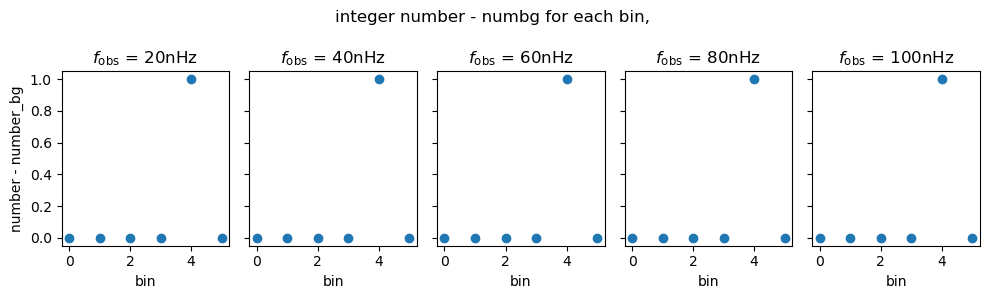

In [41]:
# test
hc_bg_ndar, hc_ss_ndar, hsamp_ndar, ssidx_ndar, maxhs_ndar, bgnum_ndar, ssnew_ndar\
    = run_example_tests(edges, number, fobs, print_test=True)

## 2.3 Plots

### BG, SS, and TT Strain

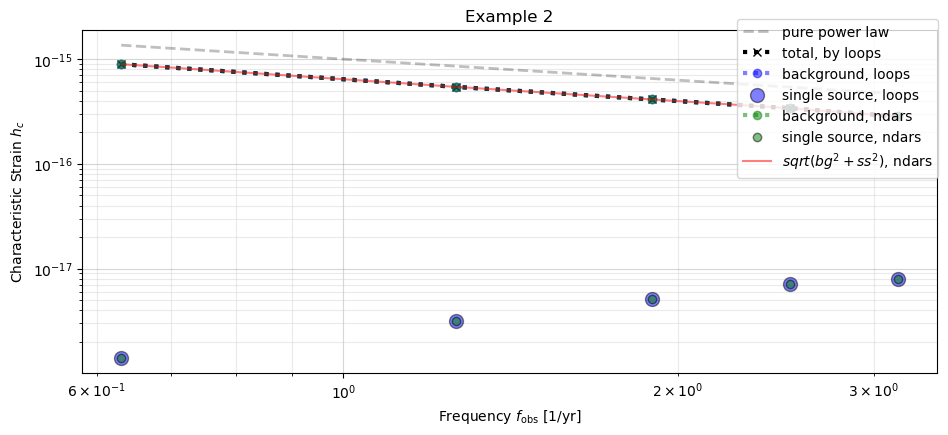

In [42]:
# quick plot
fig, ax = plot.figax(xlabel='Frequency $f_\mathrm{obs}$ [1/yr]', 
                    ylabel='Characteristic Strain $h_c$', figsize=[10,4.5])
ax.set_title(exname)
xx = fobs * YR

# plot a reference, pure power-law  strain spectrum:   h_c(f) = 1e-15 * (f * yr) ^ -2/3
yy = 1e-15 * np.power(xx, -2.0/3.0)
ax.plot(xx, yy, 'k--', alpha=0.25, lw=2.0, label = 'pure power law')

# total char strain (no sources subtracted)
ax.plot(xx, hc_tt, color='black', marker = 'x', lw=3, 
        ls = 'dotted', alpha=1, label='total, by loops')


# by loops:
# gwb
ax.plot(xx, hc_bg_loop, color='b', marker = 'o', lw=3,
        ls = 'dotted', alpha=.5, label='background, loops')
# loudest source per bin
ax.scatter(xx, hc_ss_loop, color='b', marker = 'o', s=100,
           edgecolor='k', alpha=.5, label='single source, loops')

# by ndars:
# gwb
ax.plot(xx, hc_bg_ndar, color='g', marker = 'o', lw=3, 
        ls = 'dotted', alpha=.5, label='background, ndars')
# loudest source per bin
ax.scatter(xx, hc_ss_ndar, color='g', marker = 'o', 
           edgecolor='k', alpha=.5, label='single source, ndars')


# ax.plot(xx, hc_bg+hc_ss, color='r', label='bg + ss', alpha=.5)
ax.plot(xx, np.sqrt(hc_bg_ndar**2+hc_ss_ndar**2), color='r', 
        label=r'$sqrt (bg^2 + ss^2)$, ndars', alpha=.5)

legend_gwb = ax.legend(bbox_to_anchor=(.95,.95), 
                       bbox_transform=fig.transFigure, loc='upper right')


# ax.set_ylim(1e-16, 3e-15)
fig.tight_layout()

# 3 Medium Simple Example

## 3.1 Build Model and Calculate Strains
Build Model

In [43]:
edges, number, fobs, exname = example3(print_test=True)

Number of frequency bins: 4
  between [0.63, 3.16] 1/yr
          [20.00, 100.00] nHz
edges: [array([1.00e+39, 1.45e+39, 2.11e+39, 3.07e+39, 4.47e+39, 6.50e+39,
       9.44e+39, 1.37e+40, 2.00e+40, 2.90e+40, 4.22e+40, 6.13e+40,
       8.92e+40, 1.30e+41, 1.89e+41, 2.74e+41, 3.98e+41, 5.79e+41,
       8.42e+41, 1.22e+42, 1.78e+42, 2.59e+42, 3.76e+42, 5.47e+42,
       7.95e+42]), array([0.1 , 0.11, 0.12, 0.13, 0.15, 0.16, 0.18, 0.2 , 0.22, 0.24, 0.26,
       0.29, 0.32, 0.35, 0.38, 0.42, 0.46, 0.51, 0.56, 0.62, 0.68, 0.75,
       0.83, 0.91, 1.  ]), array([1.00e-03, 1.47e-03, 2.15e-03, 3.16e-03, 4.64e-03, 6.81e-03,
       1.00e-02, 1.47e-02, 2.15e-02, 3.16e-02, 4.64e-02, 6.81e-02,
       1.00e-01, 1.47e-01, 2.15e-01, 3.16e-01, 4.64e-01, 6.81e-01,
       1.00e+00, 1.47e+00, 2.15e+00, 3.16e+00, 4.64e+00, 6.81e+00,
       1.00e+01])]


Calculate Strains

In [44]:
# Get GW Total Strain using gws_by_ndars()
hc_tt = gws_by_ndars(edges, number, realize=False, round = True, sum=True)   
 
# Get BG and SS Strain using ss_gws_by_ndars()
# has hsamp but not sspar
hc_bg_ndar, hc_ss_ndar, hsamp_ndar, ssidx_ndar, maxhs_ndar, bgnum_ndar, ssnew_ndar\
    = ss_gws_by_ndars(edges, number, realize=False)

# Get BG and SS Strain using ss_gws_by_loops()
# has sspar, but not hsamp
hc_bg_loop, hc_ss_loop, sspar_loop, ssidx_loop, maxhs_loop, bgnum_loop\
    = ss_gws_by_loops(edges, number, realize=False)

bgnum stats after copy
 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 2.60e+02, 1.45e+04, 1.24e+07


## 3.2 Tests

bgnum stats after copy
 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 2.60e+02, 1.45e+04, 1.24e+07
max_test passed
max is at m,q,z,f = 20, 23, 18, 0 and it = 7.08e-17
max is at m,q,z,f = 17, 23, 16, 1 and it = 2.49e-17
max is at m,q,z,f = 16, 23, 18, 2 and it = 1.22e-17
max is at m,q,z,f = 15, 23, 18, 3 and it = 7.89e-18
max is at m,q,z,f = 14, 23, 18, 4 and it = 5.07e-18
ssidx test passes
maxes by hsamp[ssnew[0], ssnew[1], ssnew[2], ssnew[3]] are: [7.08e-17 2.49e-17 1.22e-17 7.89e-18 5.07e-18]
ssnew test passes
number test passed
compare to loops test passed
percent error between (hc_bg^2+hc_ss^2) and hc_tt^2: [-2.09e-16  0.00e+00  1.61e-16  0.00e+00  1.12e-16]
differences between np.sqrt((hc_bg^2+hc_ss^2)) and hc_tt: [0.00e+00 0.00e+00 2.47e-32 0.00e+00 0.00e+00]
quadratic sum test passed


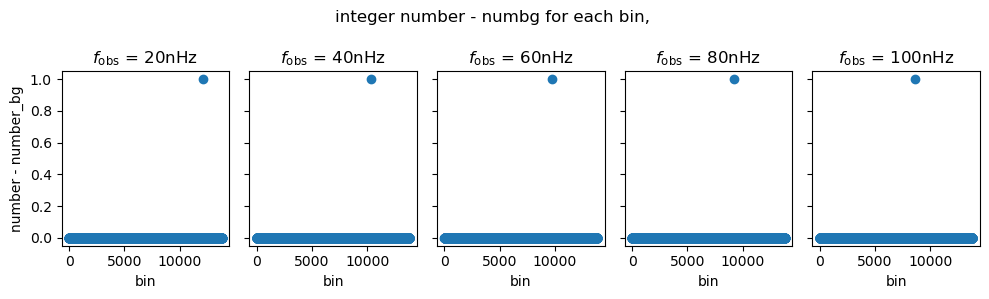

In [45]:
# test
hc_bg_ndar, hc_ss_ndar, hsamp_ndar, ssidx_ndar, maxhs_ndar, bgnum_ndar, ssnew_ndar\
    = run_example_tests(edges, number, fobs, print_test=True)

## 3.3 Plots

### BG, SS, and TT Strain

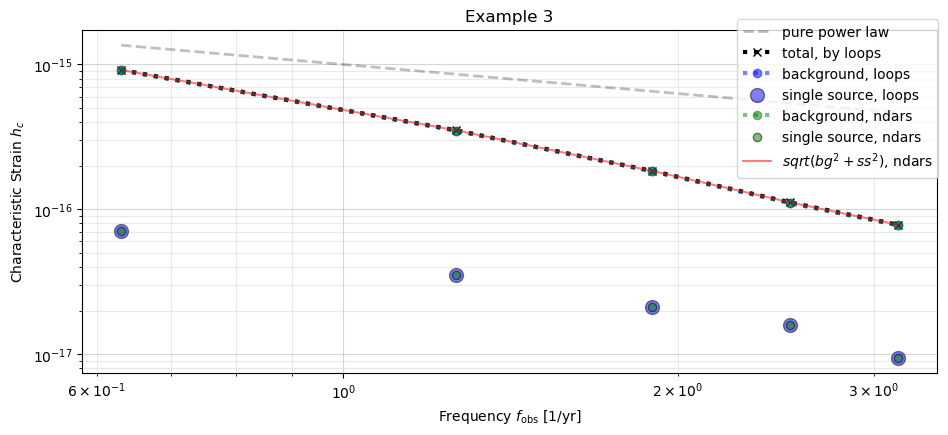

In [46]:
# quick plot
fig, ax = plot.figax(xlabel='Frequency $f_\mathrm{obs}$ [1/yr]', 
                    ylabel='Characteristic Strain $h_c$', figsize=[10,4.5])
ax.set_title(exname)
xx = fobs * YR

# plot a reference, pure power-law  strain spectrum:   h_c(f) = 1e-15 * (f * yr) ^ -2/3
yy = 1e-15 * np.power(xx, -2.0/3.0)
ax.plot(xx, yy, 'k--', alpha=0.25, lw=2.0, label = 'pure power law')

# total char strain (no sources subtracted)
ax.plot(xx, hc_tt, color='black', marker = 'x', lw=3, 
        ls = 'dotted', alpha=1, label='total, by loops')


# by loops:
# gwb
ax.plot(xx, hc_bg_loop, color='b', marker = 'o', lw=3,
        ls = 'dotted', alpha=.5, label='background, loops')
# loudest source per bin
ax.scatter(xx, hc_ss_loop, color='b', marker = 'o', s=100,
           edgecolor='k', alpha=.5, label='single source, loops')

# by ndars:
# gwb
ax.plot(xx, hc_bg_ndar, color='g', marker = 'o', lw=3, 
        ls = 'dotted', alpha=.5, label='background, ndars')
# loudest source per bin
ax.scatter(xx, hc_ss_ndar, color='g', marker = 'o', 
           edgecolor='k', alpha=.5, label='single source, ndars')


# ax.plot(xx, hc_bg+hc_ss, color='r', label='bg + ss', alpha=.5)
ax.plot(xx, np.sqrt(hc_bg_ndar**2+hc_ss_ndar**2), color='r', 
        label=r'$sqrt (bg^2 + ss^2)$, ndars', alpha=.5)

legend_gwb = ax.legend(bbox_to_anchor=(.95,.95), 
                       bbox_transform=fig.transFigure, loc='upper right')


# ax.set_ylim(1e-16, 3e-15)
fig.tight_layout()

# 4 Complex Example - Casting 64bit


## 4.1 Build Model and Calculate Strains
Build Model

In [47]:
edges, number, fobs, exname = example4(print_test=True)

Number of frequency bins: 11
  between [0.63, 7.57] 1/yr
          [20.00, 240.00] nHz
edges: [array([1.00e+39, 1.76e+39, 3.10e+39, 5.46e+39, 9.63e+39, 1.70e+40,
       2.99e+40, 5.26e+40, 9.27e+40, 1.63e+41, 2.87e+41, 5.06e+41,
       8.92e+41, 1.57e+42, 2.77e+42, 4.87e+42, 8.58e+42, 1.51e+43,
       2.66e+43, 4.69e+43, 8.26e+43, 1.46e+44, 2.56e+44, 4.52e+44,
       7.95e+44]), array([0.1 , 0.11, 0.12, 0.13, 0.15, 0.16, 0.18, 0.2 , 0.22, 0.24, 0.26,
       0.29, 0.32, 0.35, 0.38, 0.42, 0.46, 0.51, 0.56, 0.62, 0.68, 0.75,
       0.83, 0.91, 1.  ]), array([1.00e-03, 1.47e-03, 2.15e-03, 3.16e-03, 4.64e-03, 6.81e-03,
       1.00e-02, 1.47e-02, 2.15e-02, 3.16e-02, 4.64e-02, 6.81e-02,
       1.00e-01, 1.47e-01, 2.15e-01, 3.16e-01, 4.64e-01, 6.81e-01,
       1.00e+00, 1.47e+00, 2.15e+00, 3.16e+00, 4.64e+00, 6.81e+00,
       1.00e+01])]


Calculate Strains

In [48]:
# Get GW Total Strain using gws_by_ndars()
hc_tt = gws_by_ndars(edges, number, realize=False, round = True, sum=True)   
 
# Get BG and SS Strain using ss_gws_by_ndars()
# has hsamp but not sspar
hc_bg_ndar, hc_ss_ndar, hsamp_ndar, ssidx_ndar, maxhs_ndar, bgnum_ndar, ssnew_ndar\
    = ss_gws_by_ndars(edges, number, realize=False)

# Get BG and SS Strain using ss_gws_by_loops()
# has sspar, but not hsamp
hc_bg_loop, hc_ss_loop, sspar_loop, ssidx_loop, maxhs_loop, bgnum_loop\
    = ss_gws_by_loops(edges, number, realize=False)

bgnum stats after copy
 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 2.00e+00, 6.40e+02, 1.69e+07


## 4.2 Tests

bgnum stats after copy
 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 2.00e+00, 6.40e+02, 1.69e+07
max_test passed
max is at m,q,z,f = 13, 23, 16, 0 and it = 1.01e-16
max is at m,q,z,f = 12, 23, 18, 1 and it = 4.33e-17
max is at m,q,z,f = 10, 23, 16, 2 and it = 1.23e-17
max is at m,q,z,f = 10, 23, 18, 3 and it = 1.04e-17
max is at m,q,z,f = 9, 23, 17, 4 and it = 5.48e-18
max is at m,q,z,f = 8, 23, 16, 5 and it = 2.97e-18
max is at m,q,z,f = 8, 23, 17, 6 and it = 2.67e-18
max is at m,q,z,f = 8, 23, 18, 7 and it = 2.50e-18
max is at m,q,z,f = 7, 23, 17, 8 and it = 1.23e-18
max is at m,q,z,f = 7, 23, 17, 9 and it = 1.32e-18
max is at m,q,z,f = 6, 23, 16, 10 and it = 6.73e-19
max is at m,q,z,f = 7, 23, 18, 11 and it = 1.31e-18
ssidx test passes
maxes by hsamp[ssnew[0], ssnew[1], ssnew[2], ssnew[3]] are: [1.01e-16 4.33e-17 1.23e-17 1.04e-17 5.48e-18 2.97e-18 2.67e-18 2.50e-18
 1.23e-18 1.32e-18 6.73e-19 1.31e-18]
ssnew test passes
number test passed
compare to loops test passed
percent error betw

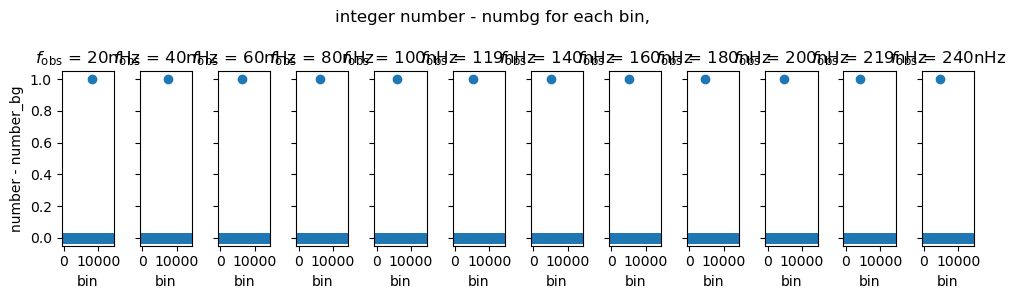

In [49]:
# test
hc_bg_ndar, hc_ss_ndar, hsamp_ndar, ssidx_ndar, maxhs_ndar, bgnum_ndar, ssnew_ndar\
    = run_example_tests(edges, number, fobs, print_test=True)

## 4.3 Plots

### BG, SS, and TT Strain

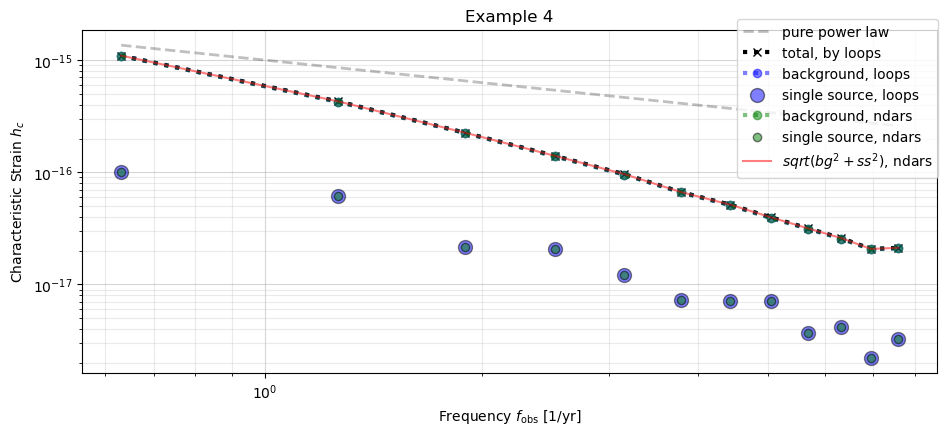

In [50]:
# quick plot
fig, ax = plot.figax(xlabel='Frequency $f_\mathrm{obs}$ [1/yr]', 
                    ylabel='Characteristic Strain $h_c$', figsize=[10,4.5])
ax.set_title(exname)
xx = fobs * YR

# plot a reference, pure power-law  strain spectrum:   h_c(f) = 1e-15 * (f * yr) ^ -2/3
yy = 1e-15 * np.power(xx, -2.0/3.0)
ax.plot(xx, yy, 'k--', alpha=0.25, lw=2.0, label = 'pure power law')

# total char strain (no sources subtracted)
ax.plot(xx, hc_tt, color='black', marker = 'x', lw=3, 
        ls = 'dotted', alpha=1, label='total, by loops')


# by loops:
# gwb
ax.plot(xx, hc_bg_loop, color='b', marker = 'o', lw=3,
        ls = 'dotted', alpha=.5, label='background, loops')
# loudest source per bin
ax.scatter(xx, hc_ss_loop, color='b', marker = 'o', s=100,
           edgecolor='k', alpha=.5, label='single source, loops')

# by ndars:
# gwb
ax.plot(xx, hc_bg_ndar, color='g', marker = 'o', lw=3, 
        ls = 'dotted', alpha=.5, label='background, ndars')
# loudest source per bin
ax.scatter(xx, hc_ss_ndar, color='g', marker = 'o', 
           edgecolor='k', alpha=.5, label='single source, ndars')


# ax.plot(xx, hc_bg+hc_ss, color='r', label='bg + ss', alpha=.5)
ax.plot(xx, np.sqrt(hc_bg_ndar**2+hc_ss_ndar**2), color='r', 
        label=r'$sqrt (bg^2 + ss^2)$, ndars', alpha=.5)

legend_gwb = ax.legend(bbox_to_anchor=(.95,.95), 
                       bbox_transform=fig.transFigure, loc='upper right')


# ax.set_ylim(1e-16, 3e-15)
fig.tight_layout()

# 5 SAM Default Example - Casting 64bit


## 5.1 Build Model and Calculate Strains
Build Model

In [51]:
edges, number, fobs, exname = example5(print_test=True)

Number of frequency bins: 24
  between [0.10, 2.50] 1/yr
          [3.17, 79.22] nHz
using default mtot, mrat, and redz
edges: [array([1.99e+37, 2.60e+37, 3.40e+37, 4.45e+37, 5.82e+37, 7.62e+37,
       9.97e+37, 1.30e+38, 1.71e+38, 2.23e+38, 2.92e+38, 3.82e+38,
       4.99e+38, 6.53e+38, 8.55e+38, 1.12e+39, 1.46e+39, 1.91e+39,
       2.50e+39, 3.27e+39, 4.28e+39, 5.60e+39, 7.33e+39, 9.59e+39,
       1.25e+40, 1.64e+40, 2.15e+40, 2.81e+40, 3.67e+40, 4.81e+40,
       6.29e+40, 8.23e+40, 1.08e+41, 1.41e+41, 1.84e+41, 2.41e+41,
       3.15e+41, 4.12e+41, 5.39e+41, 7.06e+41, 9.23e+41, 1.21e+42,
       1.58e+42, 2.07e+42, 2.70e+42, 3.54e+42, 4.63e+42, 6.05e+42,
       7.92e+42, 1.04e+43, 1.35e+43, 1.77e+43, 2.32e+43, 3.03e+43,
       3.97e+43, 5.19e+43, 6.79e+43, 8.88e+43, 1.16e+44, 1.52e+44,
       1.99e+44]), array([0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 

Calculate Strains

In [52]:
# Get GW Total Strain using gws_by_ndars()
hc_tt = gws_by_ndars(edges, number, realize=False, round = True, sum=True)   
 
# Get BG and SS Strain using ss_gws_by_ndars()
# has hsamp but not sspar
hc_bg_ndar, hc_ss_ndar, hsamp_ndar, ssidx_ndar, maxhs_ndar, bgnum_ndar, ssnew_ndar\
    = ss_gws_by_ndars(edges, number, realize=False)
hc_bg_ndar5, hc_ss_ndar5, hsamp_ndar5, ssidx_ndar5, maxhs_ndar5, bgnum_ndar5\
    = hc_bg_ndar, hc_ss_ndar, hsamp_ndar, ssidx_ndar, maxhs_ndar, bgnum_ndar

# Get BG and SS Strain using ss_gws_by_loops()
# has sspar, but not hsamp
hc_bg_loop, hc_ss_loop, sspar_loop, ssidx_loop, maxhs_loop, bgnum_loop\
    = ss_gws_by_loops(edges, number, realize=False)
hc_bg_loop5, hc_ss_loop5, sspar_loop5, ssidx_loop5, maxhs_loop5, bgnum_loop5\
    = hc_bg_loop, hc_ss_loop, sspar_loop, ssidx_loop, maxhs_loop, bgnum_loop

bgnum stats after copy
 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 1.11e+03, 5.99e+05, 5.83e+11


## 5.2 Tests

bgnum stats after copy
 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 1.11e+03, 5.99e+05, 5.83e+11
max_test passed
max is at m,q,z,f = 45, 79, 69, 0 and it = 8.18e-17
max is at m,q,z,f = 43, 79, 73, 1 and it = 4.37e-17
max is at m,q,z,f = 41, 79, 70, 2 and it = 2.69e-17
max is at m,q,z,f = 40, 79, 73, 3 and it = 1.81e-17
max is at m,q,z,f = 39, 79, 74, 4 and it = 1.29e-17
max is at m,q,z,f = 38, 79, 74, 5 and it = 9.30e-18
max is at m,q,z,f = 37, 79, 74, 6 and it = 6.58e-18
max is at m,q,z,f = 36, 79, 72, 7 and it = 5.01e-18
max is at m,q,z,f = 35, 79, 71, 8 and it = 3.63e-18
max is at m,q,z,f = 35, 79, 75, 9 and it = 3.29e-18
max is at m,q,z,f = 34, 79, 72, 10 and it = 2.53e-18
max is at m,q,z,f = 33, 79, 70, 11 and it = 1.89e-18
max is at m,q,z,f = 33, 79, 73, 12 and it = 1.73e-18
max is at m,q,z,f = 32, 79, 70, 13 and it = 1.34e-18
max is at m,q,z,f = 32, 79, 73, 14 and it = 1.22e-18
max is at m,q,z,f = 32, 79, 76, 15 and it = 1.13e-18
max is at m,q,z,f = 31, 79, 72, 16 and it = 8.82e-19


AssertionError: quadratic sum of hc_bg and hc_ss does not match hc_tt

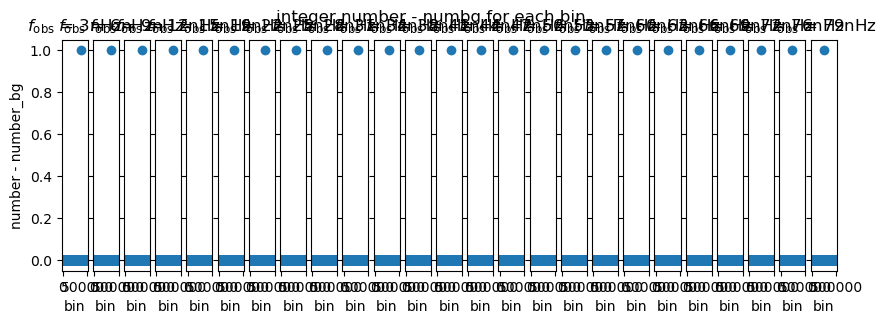

In [53]:
# test
hc_bg_ndar, hc_ss_ndar, hsamp_ndar, ssidx_ndar, maxhs_ndar, bgnum_ndar, ssnew_ndar\
    = run_example_tests(edges, number, fobs, print_test=True)

## 5.3 Plots

### BG, SS, and TT Strain

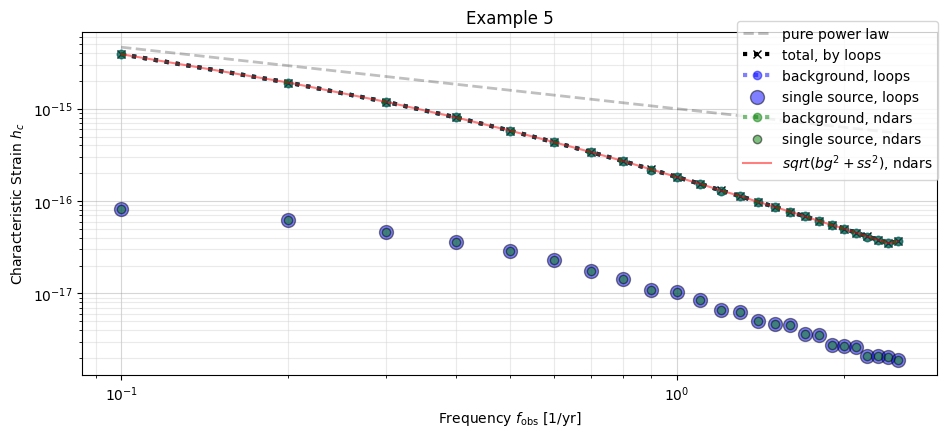

In [ ]:
# quick plot
fig, ax = plot.figax(xlabel='Frequency $f_\mathrm{obs}$ [1/yr]', 
                    ylabel='Characteristic Strain $h_c$', figsize=[10,4.5])
ax.set_title(exname)
xx = fobs * YR

# plot a reference, pure power-law  strain spectrum:   h_c(f) = 1e-15 * (f * yr) ^ -2/3
yy = 1e-15 * np.power(xx, -2.0/3.0)
ax.plot(xx, yy, 'k--', alpha=0.25, lw=2.0, label = 'pure power law')

# total char strain (no sources subtracted)
ax.plot(xx, hc_tt, color='black', marker = 'x', lw=3, 
        ls = 'dotted', alpha=1, label='total, by loops')


# by loops:
# gwb
ax.plot(xx, hc_bg_loop, color='b', marker = 'o', lw=3,
        ls = 'dotted', alpha=.5, label='background, loops')
# loudest source per bin
ax.scatter(xx, hc_ss_loop, color='b', marker = 'o', s=100,
           edgecolor='k', alpha=.5, label='single source, loops')

# by ndars:
# gwb
ax.plot(xx, hc_bg_ndar, color='g', marker = 'o', lw=3, 
        ls = 'dotted', alpha=.5, label='background, ndars')
# loudest source per bin
ax.scatter(xx, hc_ss_ndar, color='g', marker = 'o', 
           edgecolor='k', alpha=.5, label='single source, ndars')


ax.plot(xx, np.sqrt(hc_bg_ndar**2+hc_ss_ndar**2), color='r', 
        label=r'$sqrt (bg^2 + ss^2)$, ndars', alpha=.5)
# ax.plot(xx, np.sqrt(hc_bg_loop**2+hc_ss_loop**2), color='r', 
#         label=r'$sqrt (bg^2 + ss^2)$, loops', alpha=.5)

legend_gwb = ax.legend(bbox_to_anchor=(.95,.95), 
                       bbox_transform=fig.transFigure, loc='upper right')


# ax.set_ylim(1e-16, 3e-15)
fig.tight_layout()